In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='W', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(36)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33712 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37218 Dashboard: http://127.0.0.1:33712/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [3]:
!squeue -u tuchida

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          11574980      visu      viz  tuchida  R      49:36      1 n4366
8


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/const-forcing/'

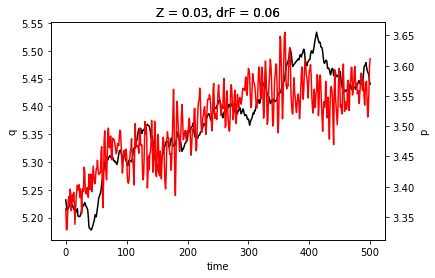

In [4]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
np.abs(xr.open_zarr(op.join(ddir,'ctrl/vars000')).q.chunk({'YC':64,'XC':64}).isel(Z=0)).mean(['YC','XC']).plot(ax=ax, c='k')
np.abs(xr.open_zarr(op.join(ddir,'ctrl/vars000')).p.chunk({'YC':64,'XC':64}).isel(Z=0)).mean(['YC','XC']).plot(ax=ax2, c='r')

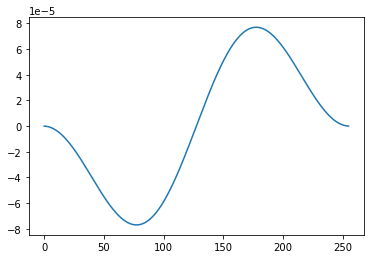

In [6]:
U = .1
tau = 5e5  # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 1500.
# f0 = 8e-5
beta = .5
N = 256    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002
ntime = 187

percent = 20
nmemb = 100

# print(Ro,beta)
ws = -tau0 * (np.sin(2*np.pi*np.arange(dx/2,L0,dx)/L0) 
              * np.sin(np.pi*np.arange(dx/2,L0,dx)/L0)
             )
plt.plot(ws)

In [8]:
def dot4D(self, other):
    dot = np.dot(self[0,0], other[0,0])
    return dot[np.newaxis,np.newaxis]

def dot5D(self, other):
    dot = np.dot(self[0,0,0], other[0,0,0])
    return dot[np.newaxis,np.newaxis,np.newaxis]


def dsar_inv(A):
    invA = xr.ones_like(A) * np.nan
    if len(A.row) == 2:
        invA[:,:,:,0,0] = A[:,:,:,1,1]
        invA[:,:,:,0,1] = -A[:,:,:,0,1]
        invA[:,:,:,1,0] = -A[:,:,:,1,0]
        invA[:,:,:,1,1] = A[:,:,:,0,0]
        invA /= (A[:,:,:,0,0]*A[:,:,:,1,1]
                 - A[:,:,:,0,1]*A[:,:,:,1,0]
                )
    else:
        invA = dsar.map_blocks(np.linalg.inv, A.chunk({'freq_YC':1,'freq_XC':1}).data).compute()
    
    return invA


def omega(ds, dx, Rom, Fr, Ekb, ws, npad=256, method='fourier'):
    
    N = len(ds.XC)
    
    if method=='fourier':
        grid = Grid(ds, periodic=[],
                    coords={'Z':{'center':'Z','outer':'Zp1'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}})

        p = xr.zeros_like(grid.interp(ds.p,'Z',boundary='fill'
                                 ).isel(Zp1=slice(1,-1))
                     ).load()
        p[:] = ((ds.drF.isel(Z=slice(1,None)).data[np.newaxis,:,np.newaxis,np.newaxis] 
                 * ds.p.isel(Z=slice(None,-1)).data
                 + ds.drF.isel(Z=slice(None,-1)).data[np.newaxis,:,np.newaxis,np.newaxis] 
                 * ds.p.isel(Z=slice(1,None)).data
                ) / (ds.drF.isel(Z=slice(1,None)).data 
                     + ds.drF.isel(Z=slice(None,-1)).data)[np.newaxis,:,np.newaxis,np.newaxis]
               )
        psi = xr.DataArray(np.zeros((len(ds.time),2,N+npad,N+npad)), dims=['time','Zp1','YC','XC'],
                            coords={'time':ds.time.data,
                                    'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                                    'YC':np.arange(dx/2-dx*npad/2,L0+dx/2+dx*npad/2,dx),
                                    'XC':np.arange(dx/2-dx*npad/2,L0+dx/2+dx*npad/2,dx)}
                           )
        psi.isel(YC=slice(npad//2,-npad//2),XC=slice(npad//2,-npad//2))[:] = p 
        lag = float(psi.XC[{'XC': psi.sizes['XC']//2}])
        dsp = psi.to_dataset(name='p')
        dsp.coords['YG'] = ('YG',np.arange(-dx*npad/2,L0+dx*npad/2,dx))
        dsp.coords['XG'] = ('XG',np.arange(-dx*npad/2,L0+dx*npad/2,dx))
        dsp.coords['Z'] = ('Z',np.array([.03,.13,.6]))
#         dsp.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
        dsp.coords['drF'] = ('Z',np.array([.06,.14,.8]))
        dsp.coords['drC'] = ('Zp1',np.array([.1,.47]))
        gridp = Grid(dsp, periodic=[],
                     coords={'Z':{'center':'Z','outer':'Zp1'},
                             'Y':{'center':'YC','left':'YG'},
                             'X':{'center':'XC','left':'XG'}}
                    )
        phat = xrft.dft(psi.chunk({'YC':-1,'XC':-1}), dim=['YC','XC'],
                        true_phase=True, true_amplitude=True
                       )

        k = 2*np.pi*phat.freq_XC
        l = 2*np.pi*phat.freq_YC
        kk, ll = np.meshgrid(k.data,l.data)
        kk = xr.DataArray(kk, dims=['freq_YC','freq_XC'],
                          coords={'freq_YC':phat.freq_YC.data, 'freq_XC':phat.freq_XC.data}
                         )
        ll = xr.DataArray(ll, dims=['freq_YC','freq_XC'],
                          coords={'freq_YC':phat.freq_YC.data, 'freq_XC':phat.freq_XC.data}
                         )

        A = xr.DataArray(np.zeros((len(ds.time),N+npad,N+npad,2,2)), 
                         dims=['time','freq_YC','freq_XC','row','col'],
                         coords={'time':ds.time.data,'freq_YC':ll.freq_YC.data,
                                 'freq_XC':kk.freq_XC.data}
                        )
        A[:,:,:,0,0] = -(Fr.isel(Zp1=0)**-2 * (kk**2+ll**2)
                         + 2*Rom**-2 / (ds.drF.isel(Z=0)*ds.drF.isel(Z=1))
                        )
        A[:,:,:,0,1] = 2*Rom**-2 / (ds.drF.isel(Z=1) * (ds.drF.isel(Z=0)+ds.drF.isel(Z=1)))
        A[:,:,:,1,0] = 2*Rom**-2 / (ds.drF.isel(Z=1) * (ds.drF.isel(Z=1)+ds.drF.isel(Z=2)))
        A[:,:,:,1,1] = -(Fr.isel(Zp1=1)**-2 * (kk**2+ll**2)
                         + 2*Rom**-2 / (ds.drF.isel(Z=1)*ds.drF.isel(Z=2))
                        )
#         invA = xr.ones_like(A) * np.nan
#         invA[:,:,:,0,0] = A[:,:,:,1,1]
#         invA[:,:,:,0,1] = -A[:,:,:,0,1]
#         invA[:,:,:,1,0] = -A[:,:,:,1,0]
#         invA[:,:,:,1,1] = A[:,:,:,0,0]
#         invA /= (A[:,:,:,0,0]*A[:,:,:,1,1]
#                  - A[:,:,:,0,1]*A[:,:,:,1,0]
#                 )
        invA = dsar_inv(A)

        uhat = -1j*phat*ll
        vhat = 1j*phat*kk
        _, ww = np.meshgrid(ds.XC, ws)
        wspad = xr.zeros_like(psi.isel(Zp1=0))
        wspad.isel(YC=slice(npad//2,-npad//2),XC=slice(npad//2,-npad//2))[:] = ww
        wshat = xrft.dft(wspad.chunk({'YC':-1,'XC':-1}), dim=['YC','XC'],
                         true_phase=True, true_amplitude=True
                        ).compute()

        psi = xr.DataArray(np.zeros((len(ds.time),len(ds.Z),N+npad,N+npad)), 
                           dims=['time','Z','YC','XC'],
                           coords={'time':ds.time.data,
                                   'Z':ds.Z.data,
                                   'YC':np.arange(dx/2-dx*npad/2,L0+dx/2+dx*npad/2,dx),
                                   'XC':np.arange(dx/2-dx*npad/2,L0+dx/2+dx*npad/2,dx)}
                          )
        psi.isel(YC=slice(npad//2,-npad//2),XC=slice(npad//2,-npad//2))[:] = ds.p.data
        dsp = psi.to_dataset(name='p')
        dsp.coords['YG'] = ('YG',np.arange(-dx*npad/2,L0+dx*npad/2,dx))
        dsp.coords['XG'] = ('XG',np.arange(-dx*npad/2,L0+dx*npad/2,dx))
#         dsp.coords['Z'] = ('Z',np.array([.03,.13,.6]))
        dsp.coords['Zp1'] = ('Zp1',ds.Zp1.data)
        dsp.coords['drF'] = ('Z',np.array([.06,.14,.8]))
        dsp.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
        gridp = Grid(dsp, periodic=[],
                     coords={'Z':{'center':'Z','outer':'Zp1'},
                             'Y':{'center':'YC','left':'YG'},
                             'X':{'center':'XC','left':'XG'}}
                    )
        phat = xrft.dft(psi.chunk({'YC':-1,'XC':-1}), dim=['YC','XC'],
                        true_phase=True, true_amplitude=True
                       )
        
        zetahat = -phat * (kk**2 + ll**2)
        wbhat = .5*dEk * zetahat.isel(Z=-1).compute()

        bhat = (-gridp.diff(phat,'Z',boundary='fill')
                / (dsp.drC)).isel(Zp1=slice(1,-1)) / Rom

        Q1_F = (xrft.idft(1j*uhat*kk, dim=['freq_YC','freq_XC'],
                          true_phase=True, true_amplitude=True, lag=(lag,lag)
                         )
                * xrft.idft(1j*bhat*kk, dim=['freq_YC','freq_XC'],
                            true_phase=True, true_amplitude=True, lag=(lag,lag)
                           )
                + xrft.idft(1j*vhat*kk, dim=['freq_YC','freq_XC'],
                            true_phase=True, true_amplitude=True, lag=(lag,lag)
                           )
                * xrft.idft(1j*bhat*ll, dim=['freq_YC','freq_XC'],
                            true_phase=True, true_amplitude=True, lag=(lag,lag)
                           )
               )
#         Q1_F[:,:npad//2,:] *= 0.
#         Q1_F[:,-npad//2:,:] *= 0.
#         Q1_F[:,:,:npad//2] *= 0.
#         Q1_F[:,:,-npad//2:] *= 0.
        Q2_F = (xrft.idft(1j*uhat*ll, dim=['freq_YC','freq_XC'],
                          true_phase=True, true_amplitude=True, lag=(lag,lag)
                         )
                * xrft.idft(1j*bhat*kk, dim=['freq_YC','freq_XC'],
                            true_phase=True, true_amplitude=True, lag=(lag,lag)
                           )
                + xrft.idft(1j*vhat*ll, dim=['freq_YC','freq_XC'],
                            true_phase=True, true_amplitude=True, lag=(lag,lag)
                           )
                * xrft.idft(1j*bhat*ll, dim=['freq_YC','freq_XC'],
                            true_phase=True, true_amplitude=True, lag=(lag,lag)
                           )
               )
#         Q2_F[:,:npad//2,:] *= 0.
#         Q2_F[:,-npad//2:,:] *= 0.
#         Q2_F[:,:,:npad//2] *= 0.
#         Q2_F[:,:,-npad//2:] *= 0.

        B1hat = (1j*beta*bhat*kk).compute()
        B0hat = xr.zeros_like(B1hat)
        B0hat.isel(Zp1=0)[:] = -(2*Rom**-2 / (ds.drF.isel(Z=0) * (ds.drF.isel(Z=0)+ds.drF.isel(Z=1)))
                                 * wshat)
        B0hat.isel(Zp1=1)[:] = -(2*Rom**-2 / (ds.drF.isel(Z=2) * (ds.drF.isel(Z=1)+ds.drF.isel(Z=2)))
                                 * wbhat)
            
        Q1_Fhat = xrft.dft(Q1_F, dim=['YC','XC'],
                           true_phase=True, true_amplitude=True
                          )
        Q2_Fhat = xrft.dft(Q2_F, dim=['YC','XC'],
                           true_phase=True, true_amplitude=True
                          )
        B2hat = -2j*(xr.DataArray(Q1_Fhat.data, dims=B1hat.dims,
                                  coords=B1hat.coords
                                 ) * kk
                     + xr.DataArray(Q2_Fhat.data, dims=B1hat.dims,
                                    coords=B1hat.coords
                                   ) * ll
                    ).compute()

        Bhat = B0hat + B1hat + B2hat
        BB = xr.concat([Bhat,Bhat], 'col').transpose('time','freq_YC','freq_XC','Zp1','col')
        
        what = xr.ones_like(Bhat, dtype=np.complex128
                           ).transpose('time','freq_YC','freq_XC','Zp1') * np.nan
#         for it in range(len(ds.time)):
# #             for j in range(N+npad):
# #                 for i in range(N+npad):
# #                     what.isel(time=it,freq_YC=j,freq_XC=i
# #                              )[:] = np.dot(invA.isel(freq_YC=j,freq_XC=i),
# #                                            Bhat.isel(time=it,freq_YC=j,freq_XC=i)[:]
# #                                           )
#             what.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                       freq_XC=slice(None,(N+npad)//4)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                                                              freq_XC=slice(None,(N+npad)//4)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                                                     freq_XC=slice(None,(N+npad)//4)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                       freq_XC=slice((N+npad)//4,(N+npad)//2)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                                                              freq_XC=slice((N+npad)//4,(N+npad)//2)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                                                     freq_XC=slice((N+npad)//4,(N+npad)//2)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                       freq_XC=slice((N+npad)//2,-(N+npad)//4)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                                                              freq_XC=slice((N+npad)//2,-(N+npad)//4)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                                                     freq_XC=slice((N+npad)//2,-(N+npad)//4)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                       freq_XC=slice(-(N+npad)//4,None)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                                                              freq_XC=slice(-(N+npad)//4,None)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice(None,(N+npad)//4),
#                                                     freq_XC=slice(-(N+npad)//4,None)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                       freq_XC=slice(None,(N+npad)//4)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                                                              freq_XC=slice(None,(N+npad)//4)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                                                     freq_XC=slice(None,(N+npad)//4)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                       freq_XC=slice((N+npad)//4,(N+npad)//2)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                                                              freq_XC=slice((N+npad)//4,(N+npad)//2)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                                                     freq_XC=slice((N+npad)//4,(N+npad)//2)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                       freq_XC=slice((N+npad)//2,-(N+npad)//4)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                                                              freq_XC=slice((N+npad)//2,-(N+npad)//4)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                                                     freq_XC=slice((N+npad)//2,-(N+npad)//4)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                       freq_XC=slice(-(N+npad)//4,None)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                                                              freq_XC=slice(-(N+npad)//4,None)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice(-(N+npad)//4,None),
#                                                     freq_XC=slice(-(N+npad)//4,None)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                       freq_XC=slice(None,(N+npad)//4)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                                                              freq_XC=slice(None,(N+npad)//4)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                                                     freq_XC=slice(None,(N+npad)//4)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                       freq_XC=slice((N+npad)//4,(N+npad)//2)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                                                              freq_XC=slice((N+npad)//4,(N+npad)//2)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                                                     freq_XC=slice((N+npad)//4,(N+npad)//2)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                       freq_XC=slice((N+npad)//2,-(N+npad)//4)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                                                              freq_XC=slice((N+npad)//2,-(N+npad)//4)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                                                     freq_XC=slice((N+npad)//2,-(N+npad)//4)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()
#             what.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                       freq_XC=slice(-(N+npad)//4,None)
#                      )[:] = dsar.map_blocks(dot4D, invA.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                                                              freq_XC=slice(-(N+npad)//4,None)
#                                                             ).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                             BB.isel(time=it,freq_YC=slice((N+npad)//4,-(N+npad)//4),
#                                                     freq_XC=slice(-(N+npad)//4,None)
#                                                    ).chunk({'freq_YC':1,'freq_XC':1}).data
#                                            )[:,:,:,0].compute()

#             what.isel(time=it)[:] = dsar.map_blocks(dot4D, invA.isel(time=it).chunk({'freq_YC':1,'freq_XC':1}).data,
#                                                     BB.isel(time=it).chunk({'freq_YC':1,'freq_XC':1}).data  
#                                                    )[:,:,:,0].compute()
        what[:] = dsar.map_blocks(dot4D, invA.chunk({'time':1,'freq_YC':1,'freq_XC':1}).data,
                                  BB.chunk({'time':1,'freq_YC':1,'freq_XC':1}).data
                                 )[:,:,:,:,0].compute()
        
        w = xrft.idft(what.chunk({'time':1,'Zp1':1}), 
                      dim=['freq_YC','freq_XC'],
                      true_phase=True, true_amplitude=True, lag=(lag,lag)
                     ).real.isel(YC=slice(npad//2,-npad//2),XC=slice(npad//2,-npad//2)
                                ).compute()
#############################
    elif method == 'multigrid':
        _, ww = np.meshgrid(ds.XC, ws/(Rom*ds.drF[0].values))
        w = xr.DataArray(np.ones((len(ds.time),2,N,N)) * np.nan,
                         dims=['time','Zp1','YC','XC'],
                         coords={'time':ds.time.data, 'Zp1':ds.Zp1.isel(Zp1=slice(1,-1)).data,
                                 'YC':ds.YC.data, 'XC':ds.XC.data}
                        ) 
        for it in range(len(ds.time)):
            w.isel(time=it)[:] = qgutils.omega.get_w(ds.p.isel(time=it).values, ds.drF.values, 
                                                     1/Fr.isel(time=it).values**2, 1/Rom, dx, 
                                                     bf = Ekb/(Rom*2*ds.drF[-1].values), 
                                                     forcing = ww
                                                    )
    else:
        raise ValueError("`method` not valid.")
    return w

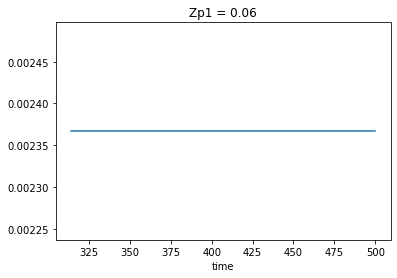

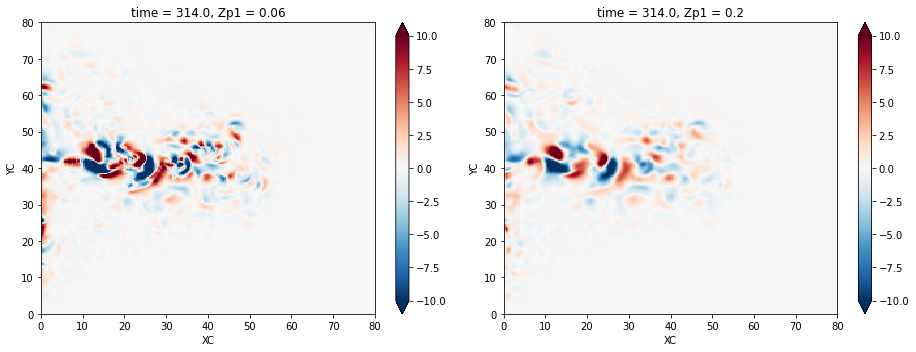

10
20
30
40
50
60
70


GroupNotFoundError: group not found at path ''

In [11]:
npad = N//2
mstart = 0
ntime = 187
# dtime = 4

for i in range(mstart,nmemb+1):
    
    if i < nmemb:
        ds = xr.open_zarr(op.join(ddir, 'run%03d/vars000' % i)
                         ).isel(time=slice(-ntime,None))
    else:
        ds = xr.open_zarr(op.join(ddir, 'ctrl/vars000')
                         ).isel(time=slice(-ntime,None))
        
#     time = ds.t
#     ds = ds.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
#     ds.coords['time'] = ('time',time.data)
#     ds.coords['timeC'] = ('timeC',.5*(time[1:].data + time[:-1].data))
#     ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
#     ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
#     ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
#     ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
#     ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
#     ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
#     ds.coords['drF'] = ('Z',np.array([.06,.14,.8]))
#     ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
#     ds = ds.chunk({'time':10,'Z':1,'Zp1':1,
#                    'YC':128,'XC':128,'YG':128,'XG':128}
#                  )
        
    if i == mstart:
        dEk = Ekb * (ds.drF.isel(Z=-1).values)
        Frm = xr.DataArray(np.array([0.0023669,0.0076173]), dims='Zp1', 
                           coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))})
        aFrN = xr.DataArray(np.array([0.,0.]), dims='Zp1', 
                            coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))})
        fFr_r = 62.2
        Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*ds.time)*aFrN)**-1 * Frm
        
        Fr.isel(Zp1=0).plot()
        plt.show()

    w = omega(ds,dx,Rom,Fr,Ekb,ws,method='multigrid')

    if i == mstart:
        fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
        fig.set_tight_layout(True)
        (w.isel(time=0,Zp1=0) * (U*H/Rd)*86400).plot(ax=ax1, vmax=1e1)
        (w.isel(time=0,Zp1=1) * (U*H/Rd)*86400).plot(ax=ax2, vmax=1e1)
        plt.show()

    dsave = w.to_dataset(name='w')

    if i < nmemb:
        dsave.chunk({'time':-1,'Zp1':-1,'YC':128,'XC':128}
                   ).to_zarr(op.join(ddir, 'run%03d/W000/' % (i)),
                             mode='w')
    else:
        dsave.chunk({'time':-1,'Zp1':-1,'YC':128,'XC':128}
                   ).to_zarr(op.join(ddir, 'ctrl/W000/'), mode='w')


        
    if i % 10 == 0:
        print(i)
    dsave.close()
    ds.close()

In [ ]:
fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(xr.open_zarr(op.join(ddir,'ctrl/W000/')).w.isel(time=0,Zp1=0) * (U*H/Rd)*86400).plot(ax=ax1, vmax=1e1)
(xr.open_zarr(op.join(ddir,'ctrl/W000/')).w.isel(time=0,Zp1=1) * (U*H/Rd)*86400).plot(ax=ax2, vmax=1e1)
plt.show()